from https://keras.io/examples/generative/wgan_gp/

# 데이터 준비

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Reshape
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

In [ ]:
# IMG_SHAPE = (28, 28, 1)
IMG_SHAPE = (32, 32, 3)
BATCH_SIZE = 512

noise_dim = 128

# dataset = keras.datasets.mnist
# dataset = keras.datasets.fashion_mnist
dataset = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = dataset.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5


170508288/170498071 [==============================] - 2s 0us/step
Number of examples: 50000
Shape of the images in the dataset: (32, 32, 3)


# D 정의

In [ ]:
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = Input(shape=IMG_SHAPE)
    # 28x28 영상을 32x32로 만드릭 위해 padding 한다.
    # x = ZeroPadding2D((2, 2))(img_input)
    x = img_input
    x = conv_block(x,  64, (5, 5), use_dropout=False)
    x = conv_block(x, 128, (5, 5), use_dropout=True)
    x = conv_block(x, 256, (5, 5), use_dropout=True)
    x = conv_block(x, 512, (5, 5), use_dropout=False)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 16, 16, 64)   4864        ['input_8[0][0]']                
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)     multiple             0           ['conv2d_21[0][0]',              
                                                                  'conv2d_22[0][0]',              
                                                                  'conv2d_23[0][0]',              
                                                                  'conv2d_24[0][0]']  

# G 정의


In [ ]:

def upsample_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bn=True,
    use_bias=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = Input(shape=(noise_dim,))
    x = Dense(4 * 4 * 256, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((4, 4, 256))(x)
    x = upsample_block(x, 128, )
    x = upsample_block(x,  64, )
    # x = upsample_block(x,   1, activation=Activation("tanh"))
    x = upsample_block(x,   3, activation=Activation("tanh"))
    # 생성된 이미지 32x32를 28x28로 만들기 위해 cropping한다.
    # x = Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 4096)         524288      ['input_9[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 4096)        16384       ['dense_7[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_12 (LeakyReLU)     (None, 4096)         0           ['batch_normalization_12[

# WGAN-GP 모델 정의

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        # D 학습

        # D는 G에 비해 d_steps 배 학습함.
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # G 학습
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 에폭 마다 결과 보는 callback

In [ ]:
import matplotlib.pyplot as plt

class GANMonitor(Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        print("epoch",epoch)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        # generated_images = (generated_images * 127.5) + 127.5
        generated_images = (generated_images + 1.0) / 2.0

        plt.figure(figsize=(10, 3))
        for i in range(1, self.num_img):
            ax = plt.subplot(1, self.num_img, i)
            plt.imshow(generated_images[i-1].numpy().squeeze(), cmap="binary")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

        # for i in range(self.num_img):
        #     img = generated_images[i].numpy()
        #     img = keras.preprocessing.image.array_to_img(img)
        #     img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))



# 학습


Epoch 1/100
98/98 [==============================] - ETA: 0s - d_loss: -2.7714 - g_loss: -0.1849epoch 0


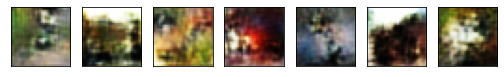

98/98 [==============================] - 15s 99ms/step - d_loss: -2.7761 - g_loss: -0.1782
Epoch 2/100
98/98 [==============================] - ETA: 0s - d_loss: -2.6838 - g_loss: -0.4143epoch 1


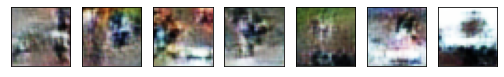

98/98 [==============================] - 10s 99ms/step - d_loss: -2.6766 - g_loss: -0.4055
Epoch 3/100
98/98 [==============================] - ETA: 0s - d_loss: -2.5439 - g_loss: -5.7532epoch 2


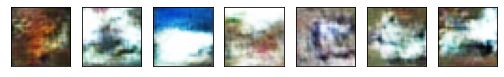

98/98 [==============================] - 10s 99ms/step - d_loss: -2.5447 - g_loss: -5.8179
Epoch 4/100
98/98 [==============================] - ETA: 0s - d_loss: -2.4728 - g_loss: -4.3752epoch 3


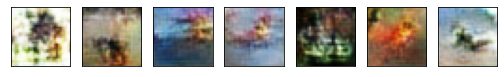

98/98 [==============================] - 10s 99ms/step - d_loss: -2.4742 - g_loss: -4.3375
Epoch 5/100
98/98 [==============================] - ETA: 0s - d_loss: -2.3180 - g_loss: -4.7051epoch 4


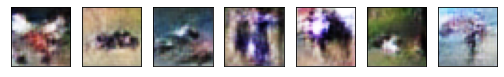

98/98 [==============================] - 10s 99ms/step - d_loss: -2.3209 - g_loss: -4.7514
Epoch 6/100
98/98 [==============================] - ETA: 0s - d_loss: -2.1906 - g_loss: -3.2190epoch 5


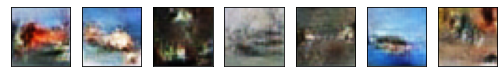

98/98 [==============================] - 10s 99ms/step - d_loss: -2.1947 - g_loss: -3.2431
Epoch 7/100
98/98 [==============================] - ETA: 0s - d_loss: -2.2387 - g_loss: -5.7294epoch 6


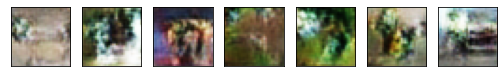

98/98 [==============================] - 10s 102ms/step - d_loss: -2.2375 - g_loss: -5.7589
Epoch 8/100
98/98 [==============================] - ETA: 0s - d_loss: -2.2155 - g_loss: -4.2723epoch 7


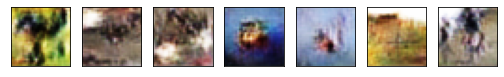

98/98 [==============================] - 10s 99ms/step - d_loss: -2.2134 - g_loss: -4.3256
Epoch 9/100
98/98 [==============================] - ETA: 0s - d_loss: -2.1302 - g_loss: -5.2526epoch 8


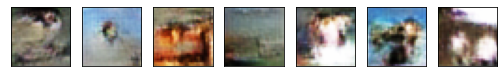

98/98 [==============================] - 10s 99ms/step - d_loss: -2.1085 - g_loss: -5.4042
Epoch 10/100
98/98 [==============================] - ETA: 0s - d_loss: -2.0267 - g_loss: -5.2476epoch 9


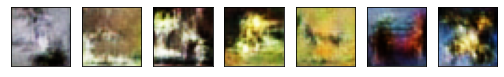

98/98 [==============================] - 10s 99ms/step - d_loss: -2.0180 - g_loss: -5.2131
Epoch 11/100
98/98 [==============================] - ETA: 0s - d_loss: -1.9475 - g_loss: -0.0604epoch 10


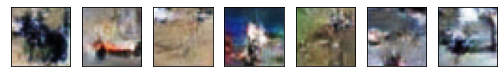

98/98 [==============================] - 10s 99ms/step - d_loss: -1.9516 - g_loss: -0.0449
Epoch 12/100
98/98 [==============================] - ETA: 0s - d_loss: -1.9246 - g_loss: -1.7693epoch 11


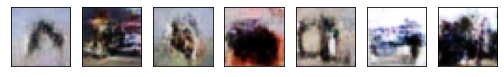

98/98 [==============================] - 10s 99ms/step - d_loss: -1.9278 - g_loss: -1.7903
Epoch 13/100
98/98 [==============================] - ETA: 0s - d_loss: -1.8492 - g_loss: -3.4210epoch 12


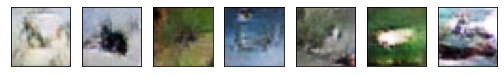

98/98 [==============================] - 10s 99ms/step - d_loss: -1.8498 - g_loss: -3.4731
Epoch 14/100
98/98 [==============================] - ETA: 0s - d_loss: -1.8071 - g_loss: -2.9520epoch 13


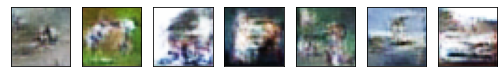

98/98 [==============================] - 10s 99ms/step - d_loss: -1.8169 - g_loss: -3.0032
Epoch 15/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7992 - g_loss: -3.0333epoch 14


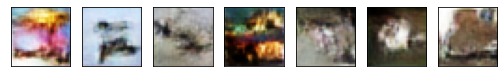

98/98 [==============================] - 10s 99ms/step - d_loss: -1.8024 - g_loss: -3.0198
Epoch 16/100
98/98 [==============================] - ETA: 0s - d_loss: -1.8227 - g_loss: -2.7775epoch 15


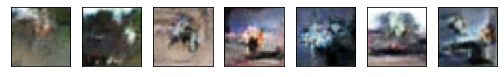

98/98 [==============================] - 10s 100ms/step - d_loss: -1.8298 - g_loss: -2.8464
Epoch 17/100
98/98 [==============================] - ETA: 0s - d_loss: -1.8134 - g_loss: -4.1779epoch 16


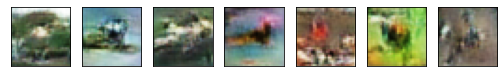

98/98 [==============================] - 10s 100ms/step - d_loss: -1.8160 - g_loss: -4.1585
Epoch 18/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7931 - g_loss: -4.6541epoch 17


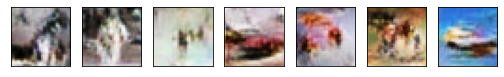

98/98 [==============================] - 10s 103ms/step - d_loss: -1.7867 - g_loss: -4.6352
Epoch 19/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7866 - g_loss: -2.5345epoch 18


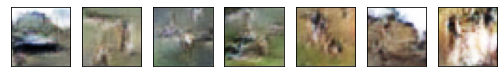

98/98 [==============================] - 10s 100ms/step - d_loss: -1.7853 - g_loss: -2.5426
Epoch 20/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7300 - g_loss: -2.5831epoch 19


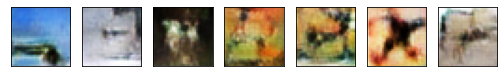

98/98 [==============================] - 10s 99ms/step - d_loss: -1.7254 - g_loss: -2.6131
Epoch 21/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7455 - g_loss: -2.4100epoch 20


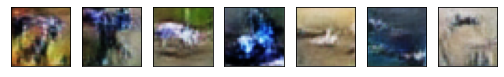

98/98 [==============================] - 10s 99ms/step - d_loss: -1.7518 - g_loss: -2.4018
Epoch 22/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7391 - g_loss: 0.3532epoch 21


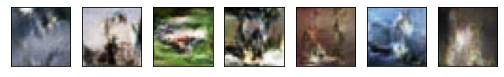

98/98 [==============================] - 10s 100ms/step - d_loss: -1.7416 - g_loss: 0.4152
Epoch 23/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6884 - g_loss: 0.0357 epoch 22


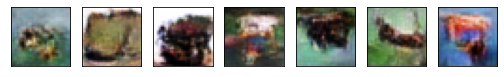

98/98 [==============================] - 10s 100ms/step - d_loss: -1.6890 - g_loss: 0.0818
Epoch 24/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6850 - g_loss: -0.1168epoch 23


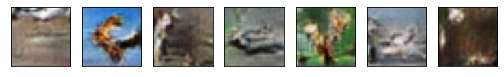

98/98 [==============================] - 10s 99ms/step - d_loss: -1.6913 - g_loss: -0.1699
Epoch 25/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7746 - g_loss: -1.0346epoch 24


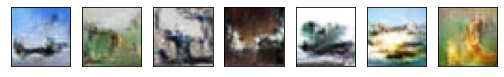

98/98 [==============================] - 10s 100ms/step - d_loss: -1.7729 - g_loss: -0.9709
Epoch 26/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7460 - g_loss: 2.3044epoch 25


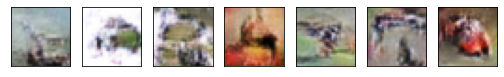

98/98 [==============================] - 10s 99ms/step - d_loss: -1.7521 - g_loss: 2.2666
Epoch 27/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7180 - g_loss: 0.1386epoch 26


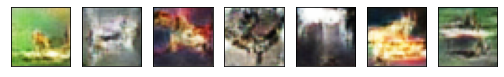

98/98 [==============================] - 10s 99ms/step - d_loss: -1.7128 - g_loss: 0.1763
Epoch 28/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7650 - g_loss: 3.3604epoch 27


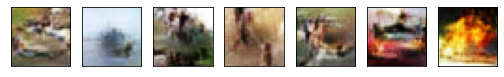

98/98 [==============================] - 10s 99ms/step - d_loss: -1.7669 - g_loss: 3.3490
Epoch 29/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7244 - g_loss: 1.9184epoch 28


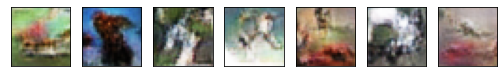

98/98 [==============================] - 10s 103ms/step - d_loss: -1.7222 - g_loss: 1.9283
Epoch 30/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7126 - g_loss: -0.3498epoch 29


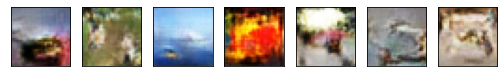

98/98 [==============================] - 10s 100ms/step - d_loss: -1.7085 - g_loss: -0.2839
Epoch 31/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7290 - g_loss: 1.3567epoch 30


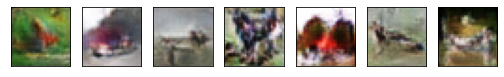

98/98 [==============================] - 10s 99ms/step - d_loss: -1.7199 - g_loss: 1.3281
Epoch 32/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6873 - g_loss: 0.7716epoch 31


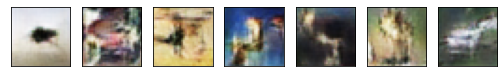

98/98 [==============================] - 10s 99ms/step - d_loss: -1.6872 - g_loss: 0.8279
Epoch 33/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6215 - g_loss: 1.1798epoch 32


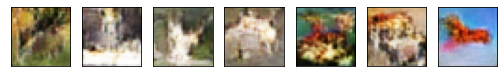

98/98 [==============================] - 10s 100ms/step - d_loss: -1.6235 - g_loss: 1.1418
Epoch 34/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7076 - g_loss: -2.8898epoch 33


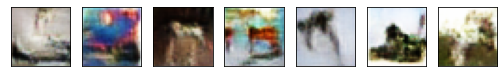

98/98 [==============================] - 10s 99ms/step - d_loss: -1.7025 - g_loss: -2.8285
Epoch 35/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6470 - g_loss: 0.5867epoch 34


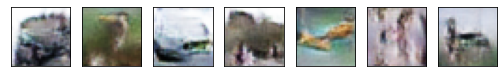

98/98 [==============================] - 10s 100ms/step - d_loss: -1.6607 - g_loss: 0.5565
Epoch 36/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6290 - g_loss: -2.1235epoch 35


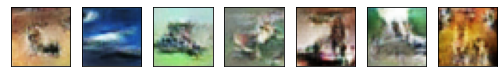

98/98 [==============================] - 10s 100ms/step - d_loss: -1.6218 - g_loss: -2.1285
Epoch 37/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6132 - g_loss: 0.8881epoch 36


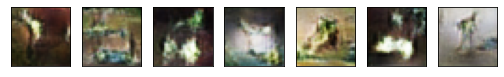

98/98 [==============================] - 10s 99ms/step - d_loss: -1.6108 - g_loss: 0.8655
Epoch 38/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5861 - g_loss: 0.3937epoch 37


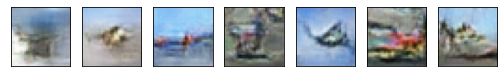

98/98 [==============================] - 10s 100ms/step - d_loss: -1.5955 - g_loss: 0.3726
Epoch 39/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5842 - g_loss: 0.2328epoch 38


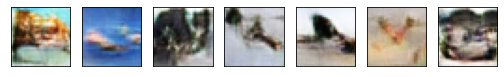

98/98 [==============================] - 10s 99ms/step - d_loss: -1.5889 - g_loss: 0.2206
Epoch 40/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5105 - g_loss: -0.9614epoch 39


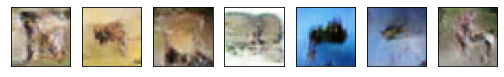

98/98 [==============================] - 10s 102ms/step - d_loss: -1.5069 - g_loss: -1.0143
Epoch 41/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5409 - g_loss: 0.3569epoch 40


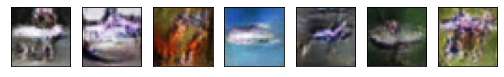

98/98 [==============================] - 10s 100ms/step - d_loss: -1.5413 - g_loss: 0.3067
Epoch 42/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5283 - g_loss: 0.5833epoch 41


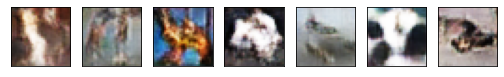

98/98 [==============================] - 10s 100ms/step - d_loss: -1.5320 - g_loss: 0.5538
Epoch 43/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5435 - g_loss: -0.3136epoch 42


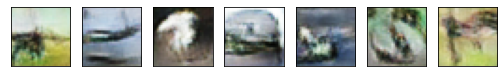

98/98 [==============================] - 10s 99ms/step - d_loss: -1.5464 - g_loss: -0.3172
Epoch 44/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5282 - g_loss: 0.9942epoch 43


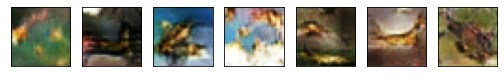

98/98 [==============================] - 10s 100ms/step - d_loss: -1.5378 - g_loss: 0.8760
Epoch 45/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5648 - g_loss: -0.9322epoch 44


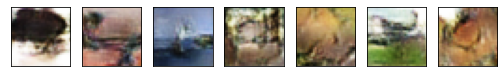

98/98 [==============================] - 10s 100ms/step - d_loss: -1.5843 - g_loss: -1.0034
Epoch 46/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5568 - g_loss: -0.6265epoch 45


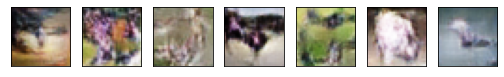

98/98 [==============================] - 10s 100ms/step - d_loss: -1.5608 - g_loss: -0.6150
Epoch 47/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4918 - g_loss: 0.3681epoch 46


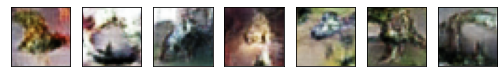

98/98 [==============================] - 10s 99ms/step - d_loss: -1.4840 - g_loss: 0.3028
Epoch 48/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5825 - g_loss: -0.5896epoch 47


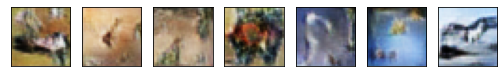

98/98 [==============================] - 10s 100ms/step - d_loss: -1.5812 - g_loss: -0.5872
Epoch 49/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5184 - g_loss: 1.0132epoch 48


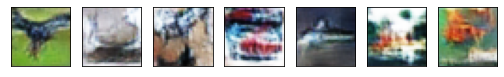

98/98 [==============================] - 10s 99ms/step - d_loss: -1.5182 - g_loss: 1.0167
Epoch 50/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4829 - g_loss: 2.4889epoch 49


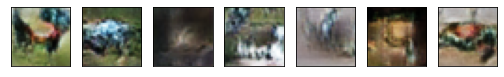

98/98 [==============================] - 10s 100ms/step - d_loss: -1.4909 - g_loss: 2.4084
Epoch 51/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5166 - g_loss: -0.0038epoch 50


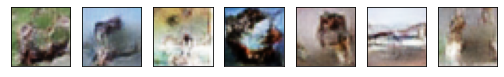

98/98 [==============================] - 10s 103ms/step - d_loss: -1.5192 - g_loss: -0.0112
Epoch 52/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4784 - g_loss: -0.1551epoch 51


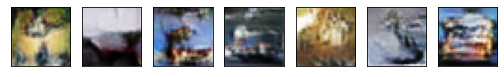

98/98 [==============================] - 10s 100ms/step - d_loss: -1.4777 - g_loss: -0.1635
Epoch 53/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4766 - g_loss: 2.9455epoch 52


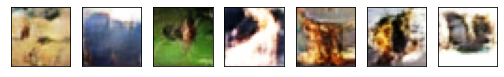

98/98 [==============================] - 10s 100ms/step - d_loss: -1.4737 - g_loss: 2.9599
Epoch 54/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4215 - g_loss: 0.7385epoch 53


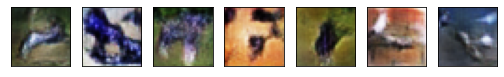

98/98 [==============================] - 10s 100ms/step - d_loss: -1.4223 - g_loss: 0.7506
Epoch 55/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4713 - g_loss: 1.7455epoch 54


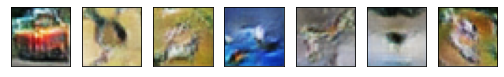

98/98 [==============================] - 10s 99ms/step - d_loss: -1.4843 - g_loss: 1.7310
Epoch 56/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4909 - g_loss: 0.7889epoch 55


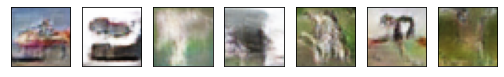

98/98 [==============================] - 10s 100ms/step - d_loss: -1.4936 - g_loss: 0.8066
Epoch 57/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4279 - g_loss: -0.9215epoch 56


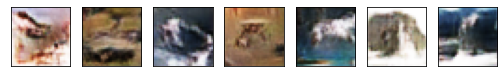

98/98 [==============================] - 10s 99ms/step - d_loss: -1.4305 - g_loss: -0.9255
Epoch 58/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4203 - g_loss: -0.3008epoch 57


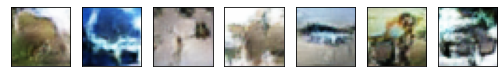

98/98 [==============================] - 10s 100ms/step - d_loss: -1.4150 - g_loss: -0.3077
Epoch 59/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3098 - g_loss: 1.4383epoch 58


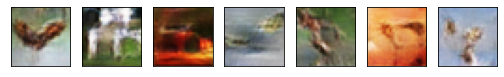

98/98 [==============================] - 10s 100ms/step - d_loss: -1.3101 - g_loss: 1.4482
Epoch 60/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4417 - g_loss: 3.8914epoch 59


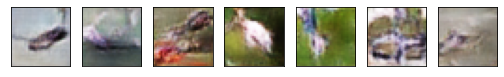

98/98 [==============================] - 10s 100ms/step - d_loss: -1.4547 - g_loss: 3.8859
Epoch 61/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3511 - g_loss: 0.7619epoch 60


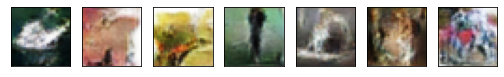

98/98 [==============================] - 10s 99ms/step - d_loss: -1.3292 - g_loss: 0.7194
Epoch 62/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2657 - g_loss: 0.9148epoch 61


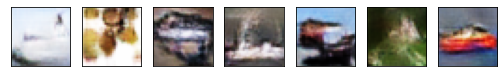

98/98 [==============================] - 10s 102ms/step - d_loss: -1.2788 - g_loss: 0.8516
Epoch 63/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4194 - g_loss: 3.0292epoch 62


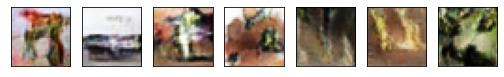

98/98 [==============================] - 10s 100ms/step - d_loss: -1.4211 - g_loss: 3.0142
Epoch 64/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2205 - g_loss: -2.2529epoch 63


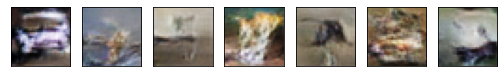

98/98 [==============================] - 10s 99ms/step - d_loss: -1.2343 - g_loss: -2.2955
Epoch 65/100
98/98 [==============================] - ETA: 0s - d_loss: -1.0764 - g_loss: -1.2268epoch 64


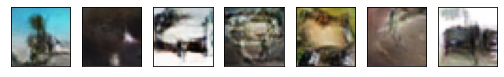

98/98 [==============================] - 10s 100ms/step - d_loss: -1.0750 - g_loss: -1.2310
Epoch 66/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3617 - g_loss: 2.0778epoch 65


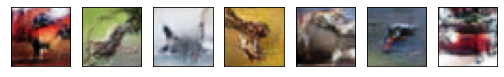

98/98 [==============================] - 10s 100ms/step - d_loss: -1.3758 - g_loss: 2.0615
Epoch 67/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2398 - g_loss: 1.8315epoch 66


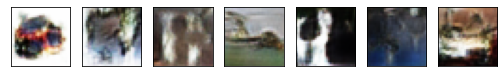

98/98 [==============================] - 10s 100ms/step - d_loss: -1.2295 - g_loss: 1.8027
Epoch 68/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3885 - g_loss: 3.2878epoch 67


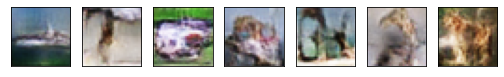

98/98 [==============================] - 10s 99ms/step - d_loss: -1.3864 - g_loss: 3.2697
Epoch 69/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2991 - g_loss: -1.1255epoch 68


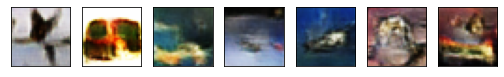

98/98 [==============================] - 10s 99ms/step - d_loss: -1.2981 - g_loss: -1.1876
Epoch 70/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3578 - g_loss: 5.0145epoch 69


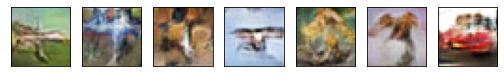

98/98 [==============================] - 10s 100ms/step - d_loss: -1.3637 - g_loss: 4.9882
Epoch 71/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3697 - g_loss: 4.2536epoch 70


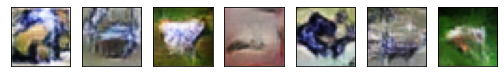

98/98 [==============================] - 10s 100ms/step - d_loss: -1.3549 - g_loss: 4.1411
Epoch 72/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3093 - g_loss: 1.6606epoch 71


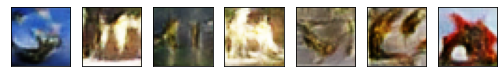

98/98 [==============================] - 10s 100ms/step - d_loss: -1.3257 - g_loss: 1.6860
Epoch 73/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2943 - g_loss: 0.7333epoch 72


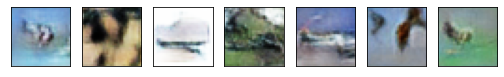

98/98 [==============================] - 10s 103ms/step - d_loss: -1.2942 - g_loss: 0.7262
Epoch 74/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3400 - g_loss: 1.1540epoch 73


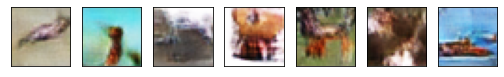

98/98 [==============================] - 10s 99ms/step - d_loss: -1.3412 - g_loss: 1.1249
Epoch 75/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2047 - g_loss: 0.0265epoch 74


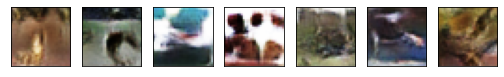

98/98 [==============================] - 10s 99ms/step - d_loss: -1.2171 - g_loss: 0.0433
Epoch 76/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3524 - g_loss: -5.5481epoch 75


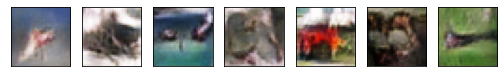

98/98 [==============================] - 10s 99ms/step - d_loss: -1.3597 - g_loss: -5.6245
Epoch 77/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1663 - g_loss: 0.2444epoch 76


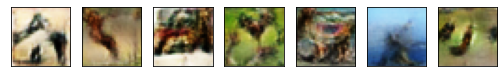

98/98 [==============================] - 10s 100ms/step - d_loss: -1.1650 - g_loss: 0.1306
Epoch 78/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1782 - g_loss: -0.9960epoch 77


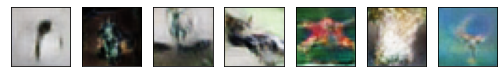

98/98 [==============================] - 10s 99ms/step - d_loss: -1.1785 - g_loss: -1.0059
Epoch 79/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1738 - g_loss: -0.0661epoch 78


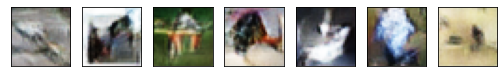

98/98 [==============================] - 10s 99ms/step - d_loss: -1.1773 - g_loss: -0.0856
Epoch 80/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2492 - g_loss: 1.3817epoch 79


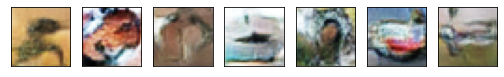

98/98 [==============================] - 10s 100ms/step - d_loss: -1.2415 - g_loss: 1.4026
Epoch 81/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1311 - g_loss: 0.6104epoch 80


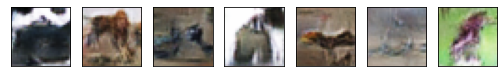

98/98 [==============================] - 10s 100ms/step - d_loss: -1.1254 - g_loss: 0.5606
Epoch 82/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2523 - g_loss: -0.3849epoch 81


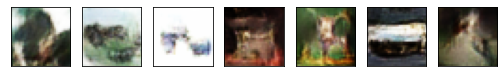

98/98 [==============================] - 10s 99ms/step - d_loss: -1.2539 - g_loss: -0.3803
Epoch 83/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2855 - g_loss: 1.5940epoch 82


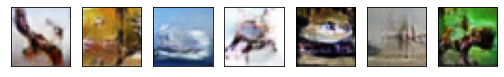

98/98 [==============================] - 10s 99ms/step - d_loss: -1.2791 - g_loss: 1.5602
Epoch 84/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1482 - g_loss: -1.8346epoch 83


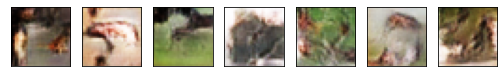

98/98 [==============================] - 10s 102ms/step - d_loss: -1.1534 - g_loss: -1.8274
Epoch 85/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1696 - g_loss: 2.1309epoch 84


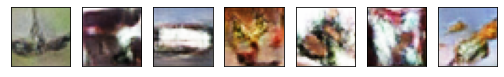

98/98 [==============================] - 10s 100ms/step - d_loss: -1.1638 - g_loss: 2.1432
Epoch 86/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1861 - g_loss: -1.1061epoch 85


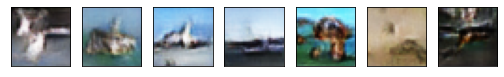

98/98 [==============================] - 10s 100ms/step - d_loss: -1.1872 - g_loss: -1.1150
Epoch 87/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1933 - g_loss: 1.3100epoch 86


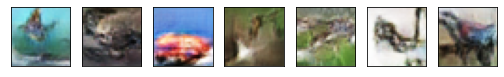

98/98 [==============================] - 10s 100ms/step - d_loss: -1.1874 - g_loss: 1.3039
Epoch 88/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1923 - g_loss: 0.4149epoch 87


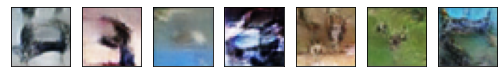

98/98 [==============================] - 10s 100ms/step - d_loss: -1.1931 - g_loss: 0.3825
Epoch 89/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1717 - g_loss: 0.9212epoch 88


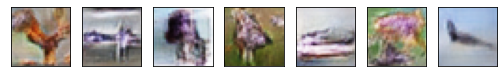

98/98 [==============================] - 10s 99ms/step - d_loss: -1.1761 - g_loss: 0.8727
Epoch 90/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1615 - g_loss: 0.8257epoch 89


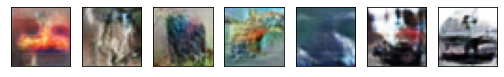

98/98 [==============================] - 10s 100ms/step - d_loss: -1.1615 - g_loss: 0.8109
Epoch 91/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2717 - g_loss: 3.5078epoch 90


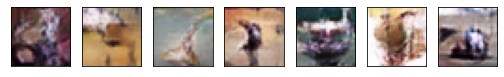

98/98 [==============================] - 10s 100ms/step - d_loss: -1.2744 - g_loss: 3.5841
Epoch 92/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1949 - g_loss: 1.1812epoch 91


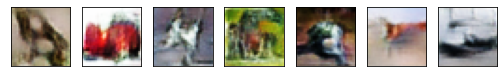

98/98 [==============================] - 10s 100ms/step - d_loss: -1.2048 - g_loss: 1.1936
Epoch 93/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1459 - g_loss: -0.1219epoch 92


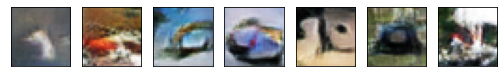

98/98 [==============================] - 10s 99ms/step - d_loss: -1.1525 - g_loss: -0.1490
Epoch 94/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1939 - g_loss: 0.9820epoch 93


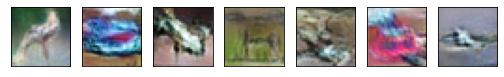

98/98 [==============================] - 10s 100ms/step - d_loss: -1.1947 - g_loss: 0.9777
Epoch 95/100
98/98 [==============================] - ETA: 0s - d_loss: -1.0935 - g_loss: -0.4865epoch 94


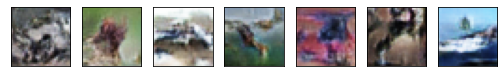

98/98 [==============================] - 10s 103ms/step - d_loss: -1.0890 - g_loss: -0.4402
Epoch 96/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1251 - g_loss: 0.3400epoch 95


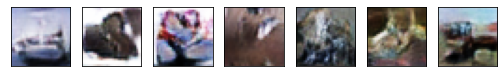

98/98 [==============================] - 10s 99ms/step - d_loss: -1.1293 - g_loss: 0.2758
Epoch 97/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1137 - g_loss: -0.5316epoch 96


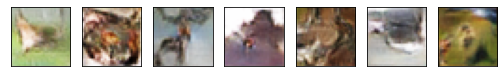

98/98 [==============================] - 10s 100ms/step - d_loss: -1.1014 - g_loss: -0.5240
Epoch 98/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1828 - g_loss: 1.9336epoch 97


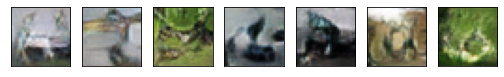

98/98 [==============================] - 10s 100ms/step - d_loss: -1.1769 - g_loss: 1.9959
Epoch 99/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1913 - g_loss: 1.2978epoch 98


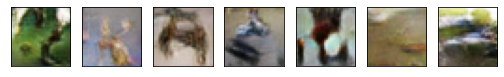

98/98 [==============================] - 10s 99ms/step - d_loss: -1.2068 - g_loss: 1.3485
Epoch 100/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1621 - g_loss: -0.2408epoch 99


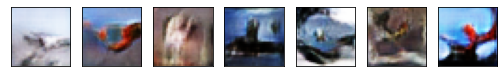

98/98 [==============================] - 10s 99ms/step - d_loss: -1.1677 - g_loss: -0.1969


In [ ]:
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

cbk = GANMonitor(num_img=8, latent_dim=noise_dim)
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=100, callbacks=[cbk])

Display the last generated images:


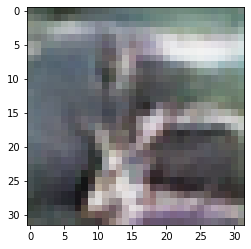

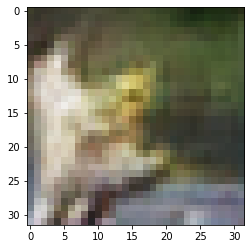

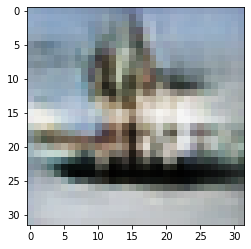

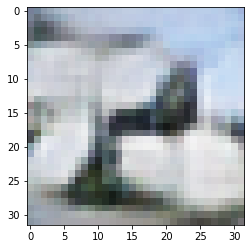

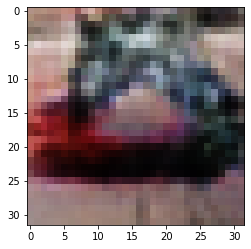

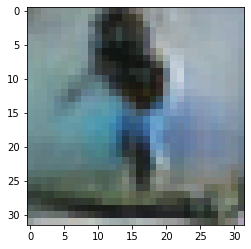

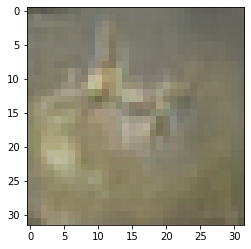

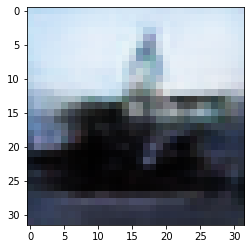

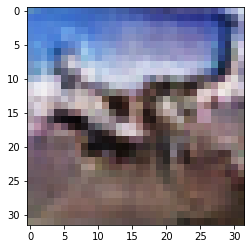

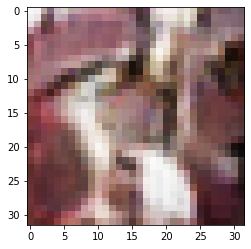

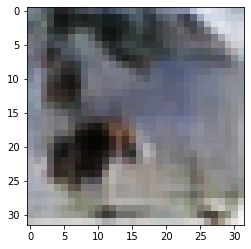

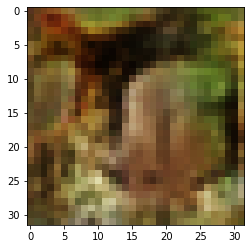

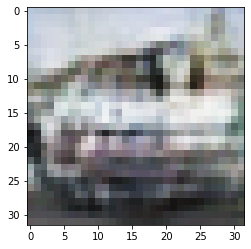

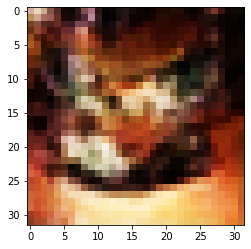

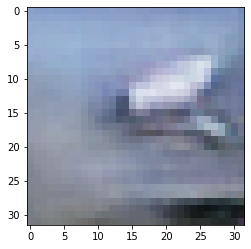

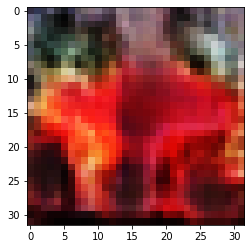

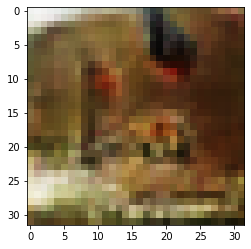

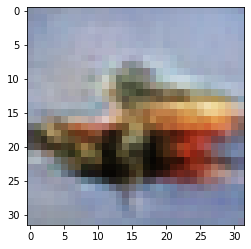

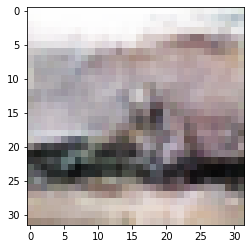

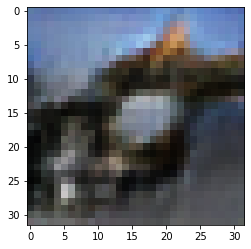

In [ ]:
import matplotlib.pyplot as plt

random_latent_vectors = tf.random.normal(shape=(20, noise_dim))

generated_images = wgan.generator(random_latent_vectors)
# generated_images = (generated_images * 127.5) + 127.5
generated_images = (generated_images + 1.) / 2.0

for image in generated_images:
  plt.imshow(image.numpy().squeeze(), cmap="binary")
  plt.show()